<a href="https://colab.research.google.com/github/gimesia/misa/blob/colab/lab5/MISA_Attention2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/lab5/')

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.utils.tensorboard as tb
import torchvision.transforms as transforms
import torch.utils.data as tData
import skimage.transform as skitr

from einops import rearrange
import datasets as d # this is your dataloader module
# import models as m # this is your model module

# device to use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #==PARAMETERS

In [4]:
BATCH_SIZE = 5 # in this case will be used for inference only
DATA_DIR = "/content/drive/MyDrive/Colab Notebooks/lab5/data/" # location of your data directory
WEIGHTS_DIR = "/content/drive/MyDrive/Colab Notebooks/lab5/weights/" # directory to save your weights (create it manually)
WEIGHTS_IN = WEIGHTS_DIR + "mod_weights_tut2.pt"
image_size = (192,192)

# model parameters
dim = 64
heads=4
blocks=3
img_dim=image_size[0]
dim_linear_block=64
patch_dim=16
patchesPerDim = int(img_dim/patch_dim)

In [5]:
transformStd = transforms.Compose([
    transforms.Resize(image_size),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
        )
    ])

In [6]:
# Create data loaders
testLd = tData.DataLoader(
    d.MessidorDataset(DATA_DIR, 'test', transformStd), batch_size=BATCH_SIZE)

print(len(testLd))

33


In [28]:
"""
Implementation of Vision Transformer (ViT) model.

Based on the paper "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale"
and Self-attention python package at
https://pypi.org/project/self-attention-cv/

"""

import torch
import torch.nn as nn
import numpy as np
from einops import rearrange



class ViT(nn.Module):
    def __init__(self, *,
                 img_dim,
                 in_channels=3,
                 patch_dim=16,
                 num_classes=10,
                 dim=512,
                 blocks=6,
                 heads=4,
                 dim_linear_block=1024,
                 dim_head=None,
                 dropout=0, transformer=None, classification=True):
        """
        Args:
            img_dim: the spatial image size
            in_channels: number of img channels
            patch_dim: desired patch dim
            num_classes: classification task classes
            dim: the linear layer's dim to project the patches for MHSA
            blocks: number of transformer blocks
            heads: number of heads
            dim_linear_block: inner dim of the transformer linear block
            dim_head: dim head in case you want to define it. defaults to dim/heads
            dropout: for pos emb and transformer
            transformer: in case you want to provide another transformer implementation
            classification: creates an extra CLS token
        """
        super().__init__()
        assert img_dim % patch_dim == 0, f'patch size {patch_dim} not divisible'
        self.p = patch_dim
        self.classification = classification
        tokens = (img_dim // patch_dim) ** 2
        self.token_dim = in_channels * (patch_dim ** 2)
        self.dim = dim
        self.dim_head = (int(dim / heads)) if dim_head is None else dim_head
        self.project_patches = nn.Linear(self.token_dim, dim)

        self.emb_dropout = nn.Dropout(dropout)
        if self.classification:
            self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
            self.pos_emb1D = nn.Parameter(torch.randn(tokens + 1, dim))
            self.mlp_head = nn.Linear(dim, num_classes)
        else:
            self.pos_emb1D = nn.Parameter(torch.randn(tokens, dim))

        if transformer is None:
            self.transformer = TransformerEncoderCust(dim, blocks=blocks, heads=heads,
                                                  dim_head=self.dim_head,
                                                  dim_linear_block=dim_linear_block,
                                                  dropout=dropout)
        else:
            self.transformer = transformer

    def expand_cls_to_batch(self, batch):
        """
        Args:
            batch: batch size
        Returns: cls token expanded to the batch size
        """
        return self.cls_token.expand([batch, -1, -1])

    def forward(self, img, mask=None):
        print(f"forward: ViT")
        batch_size = img.shape[0]
        img_patches = rearrange(
            img, 'b c (patch_x x) (patch_y y) -> b (x y) (patch_x patch_y c)',
                                patch_x=self.p, patch_y=self.p)
        # project patches with linear layer + add pos emb
        img_patches = self.project_patches(img_patches)

        if self.classification:
            img_patches = torch.cat(
                (self.expand_cls_to_batch(batch_size), img_patches), dim=1)

        patch_embeddings = self.emb_dropout(img_patches + self.pos_emb1D)

        # feed patch_embeddings and output of transformer. shape: [batch, tokens, dim]
        y = self.transformer(patch_embeddings, mask)

        if self.classification:
            # we index only the cls token for classification. nlp tricks :P
            return self.mlp_head(y[:, 0, :])
        else:
            return y

    # ADDED CODE
    # ========================================================================
    def get_attention_maps_(self, idxs=None):
      if idxs is None:
        attention_maps = [lay.mhsa.attention_map for lay in self.transformer.layers]

        return attention_maps
      else:
        attention_maps = []

        for i in idxs:
          attention_maps.append(self.transformer.layers[i].mhsa.attention_map)

        if len(attention_maps) == 1:
          return attention_maps[0]
        else:
          return [map for map in attention_maps]

    def get_attention_maps(self, idxs=None):
      attention_maps = []

      # Loop over layers in transformer
      for i, layer in enumerate(self.transformer.layers):
          # If idxs is specified, skip layers not in idxs
          if idxs is not None and i not in idxs:
              continue

          # Check if the attention map exists
          if hasattr(layer.mhsa, 'attention_map') and layer.mhsa.attention_map is not None:
              attention_maps.append(layer.mhsa.attention_map.detach().cpu())
          else:
              raise ValueError(f"Attention map not available for layer {i}. Ensure forward pass has been executed.")

      # Return single attention map if only one layer's map is requested
      if len(attention_maps) == 1:
          return attention_maps[0]
      return attention_maps
    # ========================================================================



# from transformer_vanilla.transformer_block.py in self_attention_cv package
class TransformerBlockCust(nn.Module):
    """
    Vanilla transformer block from the original paper "Attention is all you need"
    Detailed analysis: https://theaisummer.com/transformer/
    """

    def __init__(self, dim, heads=8, dim_head=None,
                 dim_linear_block=1024, dropout=0.1, activation=nn.GELU,
                 mhsa=None, prenorm=False):
        """
        Args:
            dim: token's vector length
            heads: number of heads
            dim_head: if none dim/heads is used
            dim_linear_block: the inner projection dim
            dropout: probability of droppping values
            mhsa: if provided you can change the vanilla self-attention block
            prenorm: if the layer norm will be applied before the mhsa or after
        """
        super().__init__()
        self.mhsa = mhsa if mhsa is not None else MultiHeadSelfAttentionCust(dim=dim, heads=heads, dim_head=dim_head)
        self.prenorm = prenorm
        self.drop = nn.Dropout(dropout)
        self.norm_1 = nn.LayerNorm(dim)
        self.norm_2 = nn.LayerNorm(dim)

        self.linear = nn.Sequential(
            nn.Linear(dim, dim_linear_block),
            activation(),  # nn.ReLU or nn.GELU
            nn.Dropout(dropout),
            nn.Linear(dim_linear_block, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x, mask=None):
        print(f"forward: TBC")
        if self.prenorm:
            y = self.drop(self.mhsa(self.norm_1(x), mask)) + x
            out = self.linear(self.norm_2(y)) + y
        else:
            y = self.norm_1(self.drop(self.mhsa(x, mask)) + x)
            out = self.norm_2(self.linear(y) + y)
        return out


class TransformerEncoderCust(nn.Module):
    def __init__(self, dim, blocks=6, heads=8, dim_head=None, dim_linear_block=1024, dropout=0, prenorm=False):
        super().__init__()
        self.block_list = [TransformerBlockCust(dim, heads, dim_head,
                                            dim_linear_block, dropout, prenorm=prenorm) for _ in range(blocks)]
        self.layers = nn.ModuleList(self.block_list)

    def forward(self, x, mask=None):
        print(f"forward: TEC")

        for layer in self.layers:
            x = layer(x, mask)
        return x




def compute_mhsa_cust(q, k, v, scale_factor=1, mask=None):
    print(f"compute_mhsa_cust")
    # resulted shape will be: [batch, heads, tokens, tokens]
    scaled_dot_prod = torch.einsum('... i d , ... j d -> ... i j', q, k) * scale_factor

    if mask is not None:
        assert mask.shape == scaled_dot_prod.shape[2:]
        scaled_dot_prod = scaled_dot_prod.masked_fill(mask, -np.inf)

    attention = torch.softmax(scaled_dot_prod, dim=-1)
    # calc result per head
    # ADDED CODE
    # ========================================================================
    return torch.einsum('... i j , ... j d -> ... i d', attention, v), attention
    # ========================================================================



class MultiHeadSelfAttentionCust(nn.Module):
    def __init__(self, dim, heads=8, dim_head=None):
        """
        Implementation of multi-head attention layer of the original transformer model.
        einsum and einops.rearrange is used whenever possible
        Args:
            dim: token's dimension, i.e. word embedding vector size
            heads: the number of distinct representations to learn
            dim_head: the dim of the head. In general dim_head<dim.
            However, it may not necessary be (dim/heads)
        """
        super().__init__()
        self.dim_head = (int(dim / heads)) if dim_head is None else dim_head
        _dim = self.dim_head * heads
        self.heads = heads
        self.to_qvk = nn.Linear(dim, _dim * 3, bias=False)
        self.W_0 = nn.Linear(_dim, dim, bias=False)
        self.scale_factor = self.dim_head ** -0.5

        # ADDED CODE
        # ========================================================================
        self.attention_map = None
        # ========================================================================


    def forward(self, x, mask=None):
        print(f"forward: MHSAC")
        assert x.dim() == 3
        qkv = self.to_qvk(x)  # [batch, tokens, dim*3*heads ]

        # decomposition to q,v,k and cast to tuple
        # the resulted shape before casting to tuple will be: [3, batch, heads, tokens, dim_head]
        q, k, v = tuple(rearrange(qkv, 'b t (d k h ) -> k b h t d ', k=3, h=self.heads))

        out, attention = compute_mhsa_cust(q, k, v, mask=mask, scale_factor=self.scale_factor)

        # ADDED CODE
        # ========================================================================
        self.attention_map = attention
        # ========================================================================

        # re-compose: merge heads with dim_head
        out = rearrange(out, "b h t d -> b t (h d)")
        # Apply final linear transformation layer
        return self.W_0(out)

In [29]:
# Model
encModel = TransformerEncoderCust(dim=dim, blocks=blocks, heads=heads,
                                    dim_head=(int(dim / heads)),
                                    dim_linear_block=dim_linear_block,
                                    dropout=0)

print(encModel)

TransformerEncoderCust(
  (layers): ModuleList(
    (0-2): 3 x TransformerBlockCust(
      (mhsa): MultiHeadSelfAttentionCust(
        (to_qvk): Linear(in_features=64, out_features=192, bias=False)
        (W_0): Linear(in_features=64, out_features=64, bias=False)
      )
      (drop): Dropout(p=0, inplace=False)
      (norm_1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (norm_2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (linear): Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0, inplace=False)
        (3): Linear(in_features=64, out_features=64, bias=True)
        (4): Dropout(p=0, inplace=False)
      )
    )
  )
)


In [30]:
model = ViT(img_dim=img_dim, in_channels=3, patch_dim=patch_dim,
              num_classes=2, dim=dim, blocks=blocks, heads=heads,
               dim_linear_block=dim_linear_block, dim_head=None, dropout=0,
               transformer=encModel, classification=True)

model = model.to(device)
print(model)

ViT(
  (project_patches): Linear(in_features=768, out_features=64, bias=True)
  (emb_dropout): Dropout(p=0, inplace=False)
  (mlp_head): Linear(in_features=64, out_features=2, bias=True)
  (transformer): TransformerEncoderCust(
    (layers): ModuleList(
      (0-2): 3 x TransformerBlockCust(
        (mhsa): MultiHeadSelfAttentionCust(
          (to_qvk): Linear(in_features=64, out_features=192, bias=False)
          (W_0): Linear(in_features=64, out_features=64, bias=False)
        )
        (drop): Dropout(p=0, inplace=False)
        (norm_1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm_2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (linear): Sequential(
          (0): Linear(in_features=64, out_features=64, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0, inplace=False)
          (3): Linear(in_features=64, out_features=64, bias=True)
          (4): Dropout(p=0, inplace=False)
        )
      )
    )
  )
)


In [45]:
print(f"number of parameters: {np.sum([p.numel() for p in model.parameters()])}")

number of parameters: 133570


In [46]:
# instantiate the sigmoid function for later
sig = torch.nn.Sigmoid()

In [47]:
# load model weights
model.load_state_dict(torch.load(WEIGHTS_IN, weights_only=True))
model.eval()

ViT(
  (project_patches): Linear(in_features=768, out_features=64, bias=True)
  (emb_dropout): Dropout(p=0, inplace=False)
  (mlp_head): Linear(in_features=64, out_features=2, bias=True)
  (transformer): TransformerEncoderCust(
    (layers): ModuleList(
      (0-2): 3 x TransformerBlockCust(
        (mhsa): MultiHeadSelfAttentionCust(
          (to_qvk): Linear(in_features=64, out_features=192, bias=False)
          (W_0): Linear(in_features=64, out_features=64, bias=False)
        )
        (drop): Dropout(p=0, inplace=False)
        (norm_1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm_2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (linear): Sequential(
          (0): Linear(in_features=64, out_features=64, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0, inplace=False)
          (3): Linear(in_features=64, out_features=64, bias=True)
          (4): Dropout(p=0, inplace=False)
        )
      )
    )
  )
)

In [48]:
# Get first batch
firstBatch=next(iter(testLd))
batchImg, batchLbl = firstBatch

In [49]:
# run inference
with torch.no_grad():
  inputs, labels = batchImg.float().to(device), batchLbl.to(device)
  # run model
  outputs = model(inputs)

  # You will probably want to add a line to retrieve the attention map here
  attention_maps = model.get_attention_maps() # store results

  #store results
  probRetArr = sig(outputs[:,1]).cpu().numpy()
  yRetArr = batchLbl.cpu().numpy()

forward: ViT
forward: TEC
forward: TBC
forward: MHSAC
compute_mhsa_cust
forward: TBC
forward: MHSAC
compute_mhsa_cust
forward: TBC
forward: MHSAC
compute_mhsa_cust


In [50]:
map0 = attention_maps[0]
map0.shape

torch.Size([5, 4, 145, 145])

In [51]:
# run inference
with torch.no_grad():
  inputs, labels = batchImg.float().to(device), batchLbl.to(device)

  # run model
  outputs = model(inputs)

  # You will probably want to add a line to retrieve the attention map here
  aMapLst = model.get_attention_maps() #store results


  probRetArr = sig(outputs[:,1]).cpu().numpy()
  yRetArr = batchLbl.cpu().numpy()

## only class attention:
bId = 0
print('label', labels[bId])
print('pred', outputs[bId].cpu().numpy())
lastLayerMap = aMapLst[-1].cpu().numpy()

forward: ViT
forward: TEC
forward: TBC
forward: MHSAC
compute_mhsa_cust
forward: TBC
forward: MHSAC
compute_mhsa_cust
forward: TBC
forward: MHSAC
compute_mhsa_cust
label tensor(1, device='cuda:0')
pred [-0.29074007 -0.65661263]


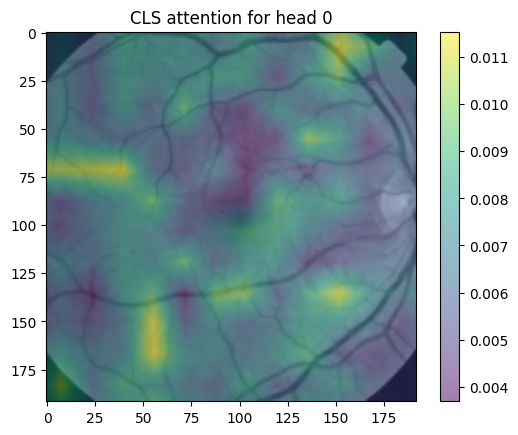

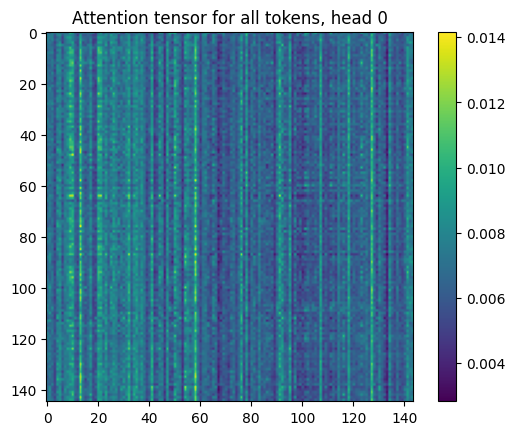

In [53]:
def plotAttMapOnImg(head_id=0, class_token_id=0):
  """ Plots the attention map of a given head on the image """
  res = rearrange(lastLayerMap[bId,head_id,class_token_id,1:], '(x0 y0) -> x0 y0', x0=patchesPerDim, y0=patchesPerDim) # resize to image_size
  res = skitr.resize(res, image_size) # plot overimposed heatmap on the image
  plt.figure()
  plt.imshow(inputs[bId,1,:,:].cpu().numpy(), cmap='gray')
  plt.imshow(res, alpha=0.5)
  plt.colorbar()
  plt.title(f'CLS attention for head {head_id}')
  plt.show() # plot attention tensor for all tokens
  plt.figure()
  plt.imshow(lastLayerMap[bId,head_id,:,1:])
  plt.colorbar()
  plt.title(f'Attention tensor for all tokens, head {head_id}')
  plt.show()

plotAttMapOnImg()

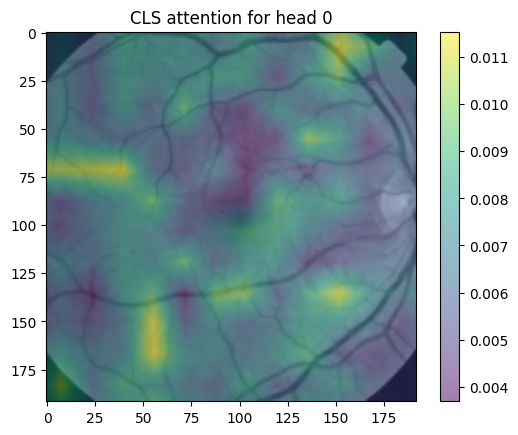

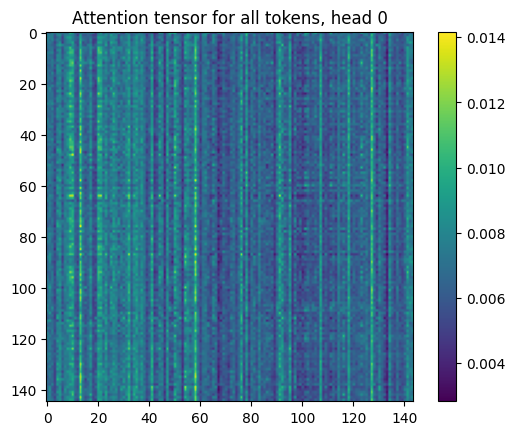

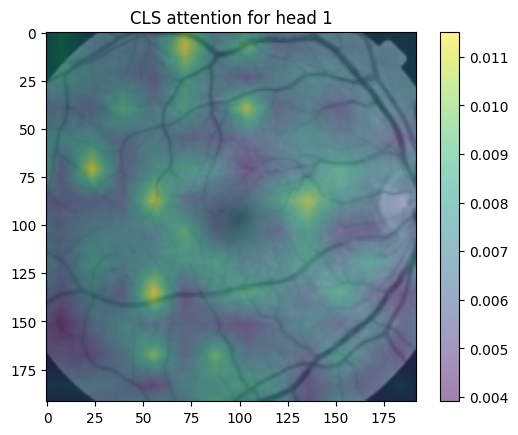

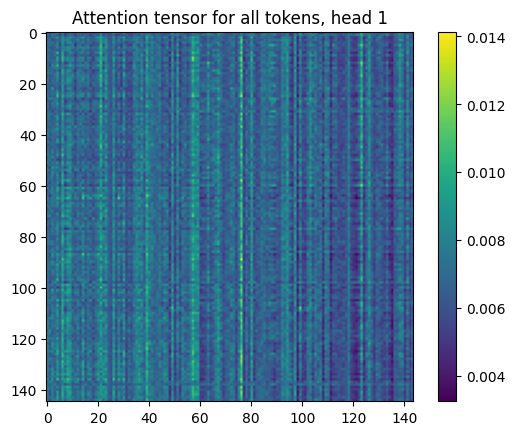

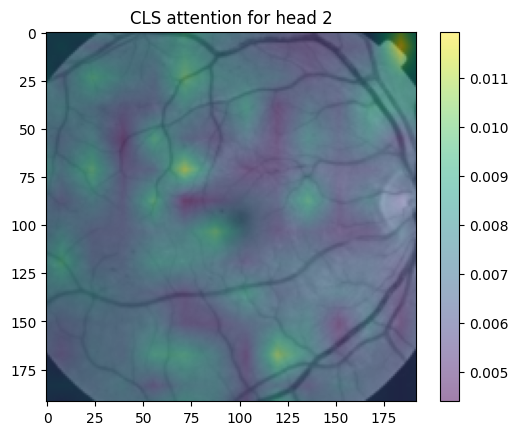

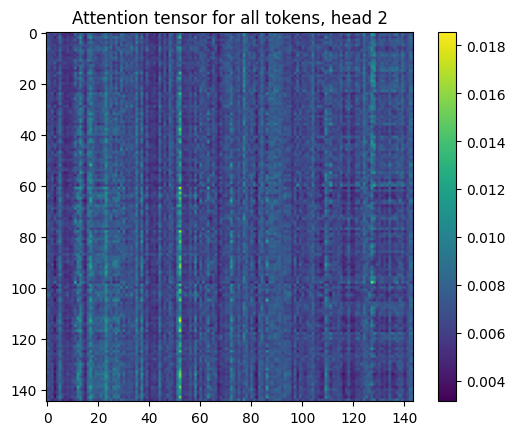

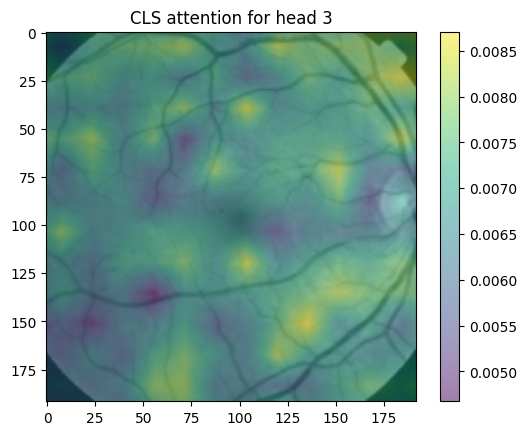

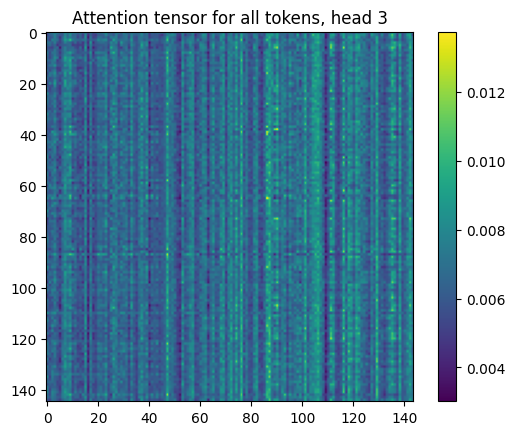

In [54]:
for i in range(heads):
  plotAttMapOnImg(i)